In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer, TFBertForSequenceClassification
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)

In [4]:
df.head()

,0,1
0,"a stirring , funny and finally transporting re...",1
1,apparently reassembled from the cutting room f...,0
2,they presume their audience wo n't sit still f...,0
3,this is a visually stunning rumination on love...,1
4,jonathan parker 's bartleby should have been t...,1


In [4]:
# Load pretrained model/tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [10]:
df[0].shape # only reviews

(6920,)

In [6]:
labels = df[1].values
# labels = torch.tensor(labels)

In [7]:
labels

array([1, 0, 0, ..., 0, 0, 1], dtype=int64)

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[0], labels, random_state=42, test_size=0.2)

In [9]:
def encode(data, tokenizer):
    input_ids = []
    attention_masks = []
    token_type_ids = []
    for text in data:
        tokenized_text = tokenizer.encode_plus(text,
                                            max_length=50,
                                            add_special_tokens = True,
                                            pad_to_max_length=True,
                                            return_attention_mask=True)
        input_ids.append(tokenized_text['input_ids'])
        attention_masks.append(tokenized_text['attention_mask'])
        token_type_ids.append(tokenized_text['token_type_ids'])
    
    return input_ids, attention_masks, token_type_ids

In [10]:
train_input_ids, train_attention_masks, train_token_type_ids = encode(X_train, tokenizer)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [11]:
test_input_ids, test_attention_masks, test_token_type_ids = encode(X_test, tokenizer)

In [12]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
      "input_ids": input_ids,
      "token_type_ids": token_type_ids,
      "attention_mask": attention_masks,
      }, label

In [13]:
def data_encode(input_ids_list, attention_mask_list, token_type_ids_list, label_list):
    return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [14]:
BATCH_SIZE = 32

In [15]:
train_data_encoded = data_encode(train_input_ids, train_attention_masks, train_token_type_ids,y_train).shuffle(10000).batch(BATCH_SIZE)

In [16]:
test_data_encoded = data_encode(test_input_ids, test_attention_masks, test_token_type_ids, y_test).batch(BATCH_SIZE)

In [17]:
model = TFBertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
#                     # You can increase this for multi-class tasks.   
#     output_attentions = False, # Whether the model returns attentions weights.
#     output_hidden_states = False, # Whether the model returns all hidden-states.
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
optimizer = tf.keras.optimizers.Adam(2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [19]:
NUM_EPOCHS = 10
history = model.fit(train_data_encoded, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=test_data_encoded)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
173/173 [==============================] - 66s 384ms/step - loss: 0.3692 - accuracy: 0.8391 - val_loss: 0.2445 - val_accuracy: 0.9104
Epoch 2/10
173/173 [==============================] - 64s 372ms/step - loss: 0.1722 - accuracy: 0.9379 - val_loss

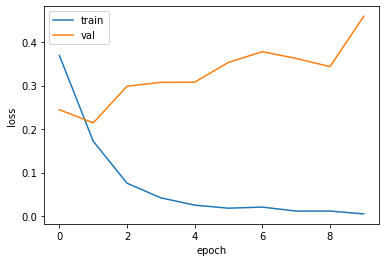

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

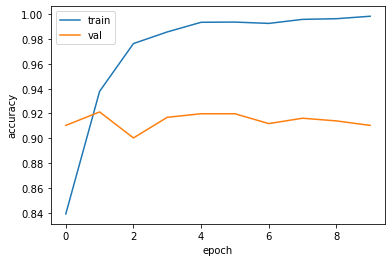

In [21]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()